# Local Homology Use Cases

In this tutorial we use tools from Topological Data Analysis (TDA) to study the local geometry of point clouds. 

In [1]:
from point_clouds import generate_point_clouds
from gtda.plotting import plot_point_cloud
from local_simplicial import *

import numpy as np

# We first generate the point clouds that we around going to use throughout the tutorial.
line, plane, cube, lines, line_plane_cube, cloud  = generate_point_clouds()

# Use case 1: Feature Augmentation
We now apply this tool as a feature augmentation tool to a heart failure dataset.
The dataset we consider is consists of 300 points, there are 12 features, which we use to predict wheher the patient suffered a heart failure. We compare the accuracy a classical logistic regression classifier, to one where we first augment the features by the local dimensionality around each point. 


The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

In [10]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.dropna(inplace=True)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [27]:
from gtda.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

train_cols = ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
X = df[train_cols].values


local_dimensions = Pipeline([
    ('localVietorisRips', LocalVietorisRipsPersistence(metric = 'euclidean', radii=(10, 80), homology_dimensions=(1, ), 
                                     n_jobs=-1)),
    ('vectorizer', PersistenceEntropy())
    ])

data_augm = FeatureUnion([
    ("identity", FunctionTransformer()),
    ("local_dimensions", local_dimensions)
    ])


pipelh = Pipeline([
    ("local_hom_augmentation", data_augm),
    ('preprocess', MinMaxScaler()),
    ('classifier', LogisticRegression()),
])

pipelh.fit(X, df["DEATH_EVENT"].values)

print('Augmented score: ', 
      pipelh.score(X, df["DEATH_EVENT"].values))

pipe = Pipeline([
    ('preprocess', MinMaxScaler()),
    ('classifier', LogisticRegression()),
])

pipe.fit(X, df["DEATH_EVENT"].values)

print('Non augmented score: ', 
      pipe.score(X, df["DEATH_EVENT"].values))

Augmented score:  0.8494983277591973
Non augmented score:  0.8461538461538461


Another Data Set: This is old.

In [28]:
# df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00571/hcvdat0.csv")
# df.dropna(inplace=True)
# df

In [29]:
# train_cols = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
# X = df[train_cols].values

# pipe = Pipeline([
#     ('local homology', local_homology(metric = 'euclidean', 
#                                      radii=(30, 70),
#                                      homology_dimensions = (1,2,3), 
#                                      n_jobs=-1)),
#     ('preprocess', MinMaxScaler()),
#     ('classifier', LogisticRegression()),
# ])


# pipe.fit(X, df["Category"].values)

# pipe2 = Pipeline([
#     ('preprocess', MinMaxScaler()),
#     ('classifier', LogisticRegression()),
# ])

# pipe2.fit(X, df["Category"].values)


# print('Augmented score: ', 
#       pipe.score(X, df["Category"].values))

# print('Original score: ', 
#       pipe2.score(X, df["Category"].values))


# Use Case 2: NLP unsupervised text disambiguation

Recent research cite!! have been looking at the the role of local homology in Natural LAnguage processing, and particularly to the task of 'détext issamgibuating'. Here we shocase a method that can be used to distinguish occurences of the word "note" when referring to a musical "note", versus when used as a word referring to text.

In [30]:
#We therefore import the libraries we will need
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.parsing.preprocessing import remove_stopwords

In [31]:
#We preprocess the data
f = open("Data/note.n.xml","r")
content = f.read()
temp_list = content.split("<note.n.")
list_of_text = list(map(remove_stopwords,temp_list))
refined_list = [list_of_text[i][1+len(str(i)):-12 - len(str(i))] for i in range(2,len(list_of_text))]

In [33]:
#we now
all_words_in_sentences = list(map(str.split,refined_list))
word2vec = Word2Vec(sentences=all_words_in_sentences, vector_size=20, window=5, min_count=1, workers=4)

#list of array with vectorized snipet
list_of_vect_sentences = [word2vec.wv[all_words_in_sentences[i]] for i in range(len(all_words_in_sentences))]

lh = LocalVietorisRipsPersistence(neighborhood = 'nb_neighbours', radii=(5, 15), homology_dimensions=(1,2), n_jobs = -1)

In [36]:
# The following sentence has "note" in it used to refer to some text
print(refined_list[0])
lh.fit(list_of_vect_sentences[0])
modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float)))

One properties print history. This recent printing activity concerning file ( records printing requests , absolute proof print actually produced ) . Note allows maximum 250 characters provide complete history; event history exceeding volume , guarantee details recent activity 


array([[1. , 0.5]])

In [37]:
# This one uses the musical note 
print(refined_list[1])
lh.fit(list_of_vect_sentences[1])
modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float)))

Lacking absolute pitch , ca n't connection-labelling note " D " , example. But connections labels hammered music lessons , babies born flair identifying pitch ? That 's hard question answer , musical parents pass passion music-as genes-on children 


array([[0.5, 0.5]])

In [38]:
#lets try UMAP:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap

In [59]:
print(refined_list[0])

One properties print history. This recent printing activity concerning file ( records printing requests , absolute proof print actually produced ) . Note allows maximum 250 characters provide complete history; event history exceeding volume , guarantee details recent activity 


Text(0.5, 1.0, 'UMAP projection of word2Vec')

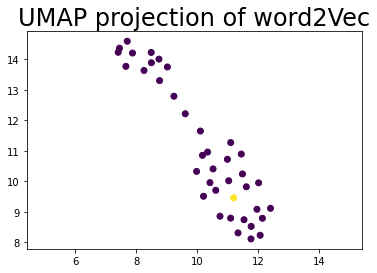

In [70]:
#This one should be 1 dimensional!
i=0
value = None
for k in range(len(list_of_vect_sentences[i])):
    if (list_of_vect_sentences[i][k] == word2vec.wv["Note"]).all(): #this one is capital leter
        value = k
temp = np.zeros((len(list_of_vect_sentences[i])))
temp[value] = 1

reducer = umap.UMAP()

scaled_point_cloud = StandardScaler().fit_transform(list_of_vect_sentences[i])

embedding = reducer.fit_transform(scaled_point_cloud)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c = temp)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of word2Vec', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of word2Vec')

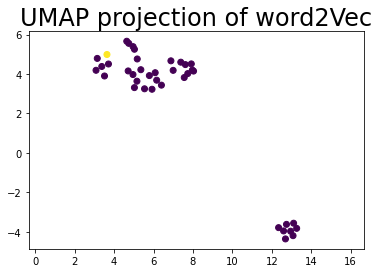

In [71]:
#This one should not be one dimensional
i=1
value=None
for k in range(len(list_of_vect_sentences[i])):
    if (list_of_vect_sentences[i][k] == word2vec.wv["note"]).all():
        value = k
temp = np.zeros((len(list_of_vect_sentences[i])))
temp[value] = 1

reducer = umap.UMAP()
scaled_point_cloud = StandardScaler().fit_transform(list_of_vect_sentences[i])

embedding = reducer.fit_transform(scaled_point_cloud)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c = temp)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of word2Vec', fontsize=24)